In [1]:
from importTDP_lib import *
from plotTDP import *
from transformers import CLIPProcessor, CLIPModel

#### Stat

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [2]:
class FIG_TO_ARR:
    def __init__(self, fig):
        assert isinstance(fig, plt.Figure), "fig must be a matplotlib figure"
        self.fig = fig

    def fig2rgb_array(self):
        self.fig.tight_layout(pad=0)
        self.fig.canvas.draw()
        buf = self.fig.canvas.tostring_rgb()
        ncols, nrows = self.fig.canvas.get_width_height()

        return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
    
    def fig_to_arr(self):
        img_arr = self.fig2rgb_array()
        return img_arr

def convert_to_arr(fig):
    assert isinstance(fig, plt.Figure), "fig must be a matplotlib figure"
    fig_to_arr = FIG_TO_ARR(fig)
    image_arr = fig_to_arr.fig_to_arr()
    return image_arr

In [4]:
def sorting_key(item:list) -> list:
    item = sorted(item, key=lambda x: (x[0], x[1:]))
    return item

In [5]:
def sorting_qualifier(df) -> list:
    unique_qualifier_by_process = df.groupby('procid')['qualifier'].unique()
    result_list = []
    for value in unique_qualifier_by_process:
        value = sorting_key(value)
        result_list.extend(value)
    return result_list

In [6]:
def filter_qualifier(df):
    qual_df = sorting_qualifier(df)
    qualifier_value = [qual[:3] for qual in qual_df]
    return  qualifier_value

In [7]:
def get_bad_head(df): 
    binary = bin(int(str(df['subcode'].values[0]),16))[2:][::-1]
    if int(binary) != 0: 
        bad_head_list = [ind for ind, val in enumerate(binary) if int(val) != 0]
    else:
        return []
    if df['product'].values[0] == 'adq' and any(val >= 9 for val in bad_head_list):
        for ind, head in enumerate(bad_head_list):
            if head >= 9:
                bad_head_list[ind] = head - 9
    return bad_head_list

In [47]:
csv_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\data\prep_data\2GHST4LW_TDMO_7.csv"
df = pd.read_csv(csv_path)

qualifier_value = filter_qualifier(df)

df = df.assign(new_qualifier = lambda x : x['qualifier'].str[:3]).sort_values(by='radius').drop_duplicates()
fail_head = get_bad_head(df)
print(fail_head)

mean_values = []
mean_values_fh = []

trend_values = []
trend_values_fh = []

max_radius = df['radius'].max()
print("Max Radius:", max_radius)

all_qual = len(qualifier_value)
first_qual = 0
last_qual = all_qual
mid_qual = int(all_qual/2)

print("All Qualifier:", all_qual)

for i, qualifier in enumerate(qualifier_value):
    data = df.loc[df['new_qualifier'] == qualifier[:3]]
    # get data from fail head
    if len(fail_head) != 0:
        df_fh = data.loc[data['head'].isin(fail_head)]
        df_gh = data.loc[~data['head'].isin(fail_head)]

    ## get mean value from good head
    mean_value = data.groupby('radius')['fittedtdtfcdactc'].mean().reset_index()
    # print("Mean GH:", mean_value)
    ## get mean value from fail head
    mean_value_fh = df_fh.groupby('radius')['fittedtdtfcdactc'].mean().reset_index()
    # print("Mean FH:", mean_value_fh)

    mean_values.append(mean_value)
    mean_values_fh.append(mean_value_fh)


    ## plot mean gh and mean bh in one plot
    # plt.figure(figsize=(10, 6))
    # plt.plot(mean_value['radius'], mean_value['fittedtdtfcdactc'], label='Good Head')
    # plt.plot(mean_value_fh['radius'], mean_value_fh['fittedtdtfcdactc'], label='Bad Head')
    # plt.xlabel('Radius')
    # plt.ylabel('Fitted TDTFCDACTC')
    # plt.title(f'Good Head vs Bad Head {qualifier}')
    # plt.legend()

## subplot
# fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# for i, ax in enumerate(axs.flat):
#     if i < len(mean_values):
#         ax.plot(mean_values[i]['radius'], mean_values[i]['fittedtdtfcdactc'], label='Good Head')
#         ax.plot(mean_values_fh[i]['radius'], mean_values_fh[i]['fittedtdtfcdactc'], label='Bad Head')
#         ax.set_title(qualifier_value[i])
#         ax.legend()
#     else:
#         ax.set_visible(False)

[7]
Max Radius: 99
All Qualifier: 15


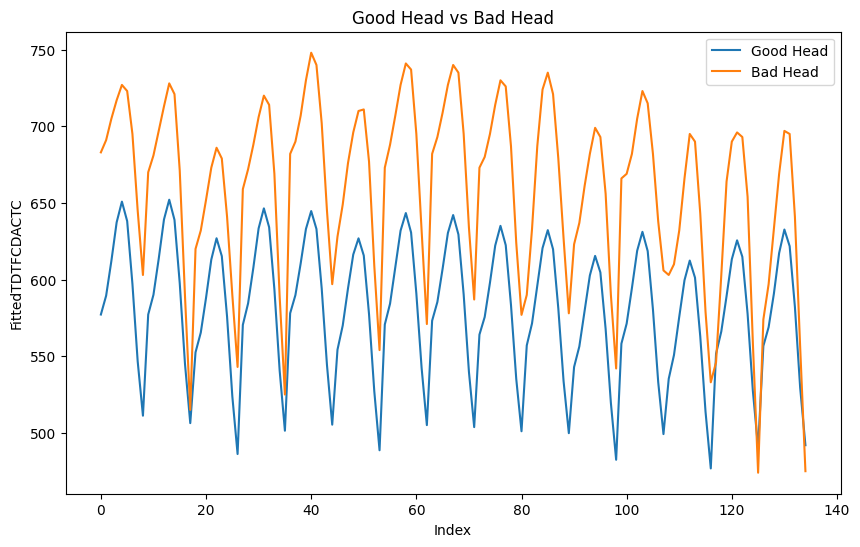

In [48]:
mean_values_df = pd.concat(mean_values)
mean_values_fh_df = pd.concat(mean_values_fh)

mean_values_df["new_index"] = [i for i in range(len(mean_values_df))]
mean_values_fh_df["new_index"] = [i for i in range(len(mean_values_fh_df))]

trend_values = np.polyfit(mean_values_df["new_index"], mean_values_df["fittedtdtfcdactc"], 1)
trend_values_fh = np.polyfit(mean_values_fh_df["new_index"], mean_values_fh_df["fittedtdtfcdactc"], 10)

## plot
plt.figure(figsize=(10, 6))
plt.plot(mean_values_df["new_index"], mean_values_df["fittedtdtfcdactc"], label='Good Head')
plt.plot(mean_values_fh_df["new_index"], mean_values_fh_df["fittedtdtfcdactc"], label='Bad Head')
# plt.plot(mean_values_df["new_index"], np.poly1d(trend_values)(mean_values_df["new_index"]), label='Good Head Trend')
# plt.plot(mean_values_fh_df["new_index"], np.poly1d(trend_values_fh)(mean_values_fh_df["new_index"]), label='Bad Head Trend')
plt.xlabel('Index')
plt.ylabel('FittedTDTFCDACTC')
plt.title(f'Good Head vs Bad Head')
plt.legend()
plt.show()

In [118]:
trend_fh_arr = np.poly1d(trend_values_fh)(mean_values_fh_df["new_index"])
trend_arr = np.poly1d(trend_values)(mean_values_df["new_index"])

max-min point of curves

Max FH Index: 4
Min FH Index 97


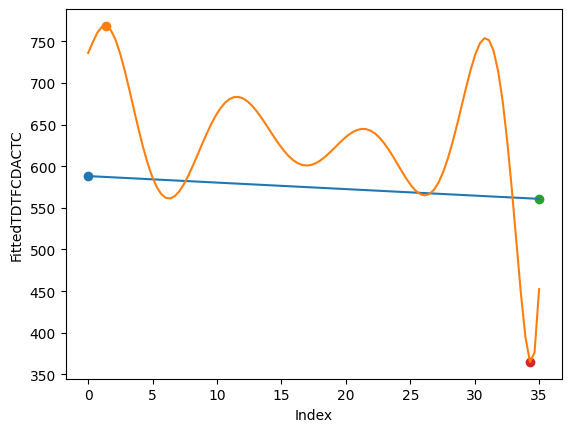

In [119]:
poly_fn = np.poly1d(trend_values)
poly_fn_fh = np.poly1d(trend_values_fh)

x_value = np.linspace(min(mean_values_df["new_index"]), max(mean_values_df["new_index"]), 100)
x_value_fh = np.linspace(min(mean_values_fh_df["new_index"]), max(mean_values_fh_df["new_index"]), 100)

y_value = poly_fn(x_value)
y_value_fh = poly_fn_fh(x_value_fh)

max_x = x_value[np.argmax(y_value)]
max_x_fh = x_value_fh[np.argmax(y_value_fh)]

min_x = x_value[np.argmin(y_value)]
min_x_fh = x_value_fh[np.argmin(y_value_fh)]

## get index of maximum point
max_index = np.argmax(y_value)
max_index_fh = np.argmax(y_value_fh)
min_index = np.argmin(y_value)
min_index_fh = np.argmin(y_value_fh)
print("Max FH Index:", max_index_fh)
print("Min FH Index", min_index_fh)

plt.plot(x_value, y_value, label='Good Head Trend')
plt.plot(x_value_fh, y_value_fh, label='Bad Head Trend')
plt.scatter(max_x, poly_fn(max_x), label='Good Head Max')
plt.scatter(max_x_fh, poly_fn_fh(max_x_fh), label='Bad Head Max')
plt.scatter(min_x, poly_fn(min_x), label='Good Head Min')
plt.scatter(min_x_fh, poly_fn_fh(min_x_fh), label='Bad Head Min')
plt.xlabel('Index')
plt.ylabel('FittedTDTFCDACTC')
plt.show()

image features

In [60]:
tdp = TDP(df=df, bad_head_list=fail_head)
fig = tdp.display()
plt.close()

image_arr = convert_to_arr(fig)
image = Image.fromarray(image_arr).convert("RGB")

inputs = processor(images=image, return_tensors="pt", padding=True)

image_features = model.get_image_features(**inputs)
image_features.shape


torch.Size([1, 768])

In [61]:
feature_cols = ["hddsn", "mean_gh", "mean_bh", "gh_c", "gh_m"]
df_feature = pd.DataFrame(columns=feature_cols)

df_feature["hddsn"] = [df["hddsn"].unique()[0]]
df_feature["mean_gh"] = [np.mean(mean_values_df['fittedtdtfcdactc'])]
df_feature["mean_bh"] = [np.mean(mean_values_fh_df['fittedtdtfcdactc'])]
df_feature["diff_mean_gh"] = [df_feature["mean_gh"].values[0] - df_feature["mean_bh"].values[0]] ## good head - bad head -> if positive, good head is higher than bad head
df_feature["diff_meanbh"] = [df_feature["mean_bh"].values[0] - df_feature["mean_gh"].values[0]] ## good head - bad head -> if positive, good head is higher than bad head
df_feature["gh_c"] = [np.poly1d(trend_values)[0]]
df_feature["gh_m"] = [np.poly1d(trend_values)[1]]

## trend values for bad head 
n_trend_values_fh = len(np.poly1d(trend_values_fh))
for i, value_fh in enumerate(np.poly1d(trend_values_fh)):
    df_feature[f"bh_coeff_deg_{n_trend_values_fh-i}"] = [value_fh]

# df_feature["bh_c"] = [np.poly1d(trend_values_fh)[0]]
# df_feature["bh_m"] = [np.poly1d(trend_values_fh)[1]]

df_feature["diff_c"] = [df_feature["gh_c"].values[0] - df_feature["bh_coeff_deg_0"].values[0]] ## good head - bad head -> if positive, good head is higher than bad head
# df_feature["diff_m"] = [df_feature["gh_m"].values[0] - df_feature["bh_m"].values[0]] ## good head - bad head -> if positive, good head is higher than bad head

for i, val in enumerate(image_features[0].detach().numpy()):
    df_feature[f"image_features_{i}"] = [val]

In [62]:
df_feature

,hddsn,mean_gh,mean_bh,gh_c,gh_m,diff_mean_gh,diff_meanbh,bh_coeff_deg_10,bh_coeff_deg_9,bh_coeff_deg_8,...,image_features_758,image_features_759,image_features_760,image_features_761,image_features_762,image_features_763,image_features_764,image_features_765,image_features_766,image_features_767
0,1QG0MDUM,782.301389,825.166667,708.148574,4.237304,-42.865278,42.865278,6.575605e-09,-0.000001,0.000083,...,-1.459283,-0.389866,-0.522139,-0.232798,-0.146631,0.047482,0.004584,-0.117614,-0.373654,-0.044447


### Feature vector

In [81]:
from transformers import CLIPProcessor, CLIPModel

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [133]:
class FIG_TO_ARR:
    def __init__(self, fig):
        assert isinstance(fig, plt.Figure), "fig must be a matplotlib figure"
        self.fig = fig

    def fig2rgb_array(self):
        self.fig.tight_layout(pad=0)
        self.fig.canvas.draw()
        buf = self.fig.canvas.tostring_rgb()
        ncols, nrows = self.fig.canvas.get_width_height()
        print(ncols, nrows)
        return np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
    
    def fig_to_arr(self):
        img_arr = self.fig2rgb_array()
        return img_arr

def convert_to_arr(fig):
    assert isinstance(fig, plt.Figure), "fig must be a matplotlib figure"
    fig_to_arr = FIG_TO_ARR(fig)
    image_arr = fig_to_arr.fig_to_arr()
    return image_arr

[6]


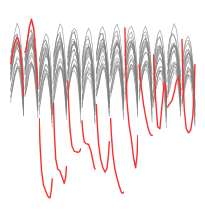

In [192]:
df = pd.read_csv(r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\data\prep_data\2HGP0GAN_TDL7_6.csv")
failure_head_list = get_bad_head(df=df)
print(failure_head_list)
tdp = TDP(df=df, bad_head_list=failure_head_list)
fig = tdp.display()
plt.show()

256 256
(256, 256)


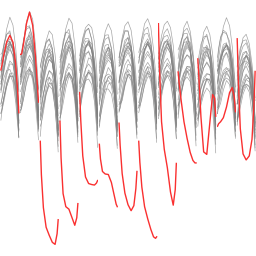

In [193]:
## convert matplotlib figure to image
image_arr = convert_to_arr(fig)
image1 = Image.fromarray(image_arr).convert('RGB')
print(image1.size)
image1

In [194]:
inputs1 = processor(images=image1, return_tensors="pt", padding=True)
image_features1 = model.get_image_features(**inputs1)
image_features1.shape

torch.Size([1, 768])

[13]


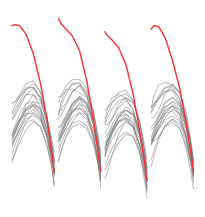

256 256
(256, 256)


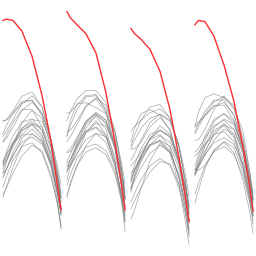

In [198]:
df = pd.read_csv(r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\data\prep_data\2HGPMWXN_TDT4_13.csv")
failure_head_list = get_bad_head(df=df)
print(failure_head_list)
tdp = TDP(df=df, bad_head_list=failure_head_list)
fig = tdp.display()
plt.show()

## convert matplotlib figure to image
image_arr = convert_to_arr(fig)
image2 = Image.fromarray(image_arr).convert('RGB')
print(image2.size)
image2

In [199]:
inputs2 = processor(images=image2, return_tensors="pt", padding=True)
image_features2 = model.get_image_features(**inputs2)
image_features2.shape

torch.Size([1, 768])

In [201]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores

In [202]:
score = compute_scores(image_features1, image_features2)
print(score)

tensor([0.9128], grad_fn=<SumBackward1>)
